In [1]:
import re
from sklearn.base import BaseEstimator, clone, RegressorMixin
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from data_manipulations import *

/home/tibo/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_features = pl.read_parquet('train_features.parquet')
train_targets = pl.read_parquet('train_targets.parquet')
test_features = pl.read_parquet('test_features.parquet')
test_targets = pl.read_parquet('test_targets.parquet')

data = prepare_data_for_ml(
    train_features, train_targets, test_features, test_targets,
)

In [3]:
# def restrict(frame, heads=(25, 20)):
#     keys = frame.columns[:2]
#     temp = join_many((
#         frame.select(keys[0]).unique().sort(by=keys[0]).head(heads[0]),
#         frame.select(keys[1]).unique().sort(by=keys[1]).head(heads[1]),
#     ), how='cross')
#     return frame.join(temp, on=keys)

# train_features = restrict(train_features)
# train_targets = restrict(train_targets)
# test_features = restrict(test_features)
# test_targets = restrict(test_targets)

# data = prepare_data_for_ml(train_features, train_targets, test_features, test_targets)
# data['train_features_rect'].shape, data['train_targets_rect'].shape

# Model

In [4]:
class SparseEN(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        sparsity=0.4,
        l1_ratio=0.83,
    ):
        self.model = MultiTaskElasticNetCV(
            l1_ratio=l1_ratio,  # 0.5
            fit_intercept=False,  # True
            n_alphas=50,  # 100
            cv=3,
            random_state=0,
            max_iter=2000,  # 1000
        )
        self.sparsity = sparsity
        self.l1_ratio = l1_ratio
        self.supports = None
        self.models = None

    def fit(self, features, targets):
        model = clone(self.model)
        model.fit(StandardScaler().fit_transform(features), targets)
        bipartite, _ = get_support(model.coef_, self.sparsity)
        assert (bipartite.sum(axis=1) > 0).all()
        self.supports = get_connected_components_supports(bipartite)

        self.models = []
        for support_features, support_targets in self.supports:
            model = make_pipeline(StandardScaler(), clone(self.model))
            model.fit(features[:, support_features], targets[:, support_targets])
            self.models.append((model, support_features, support_targets))
        return self

    def predict(self, features):
        predictions = np.zeros(features.shape)  # bof
        for model, support_features, support_targets in self.models:
            predictions[:, support_targets] = model.predict(features[:, support_features])
        return predictions

# Grid search

In [5]:
param_grid = {
    'l1_ratio': np.linspace(0.0, 1.0, 10),
    'sparsity': np.linspace(0.2, 0.9, 10),
}

model = SparseEN(l1_ratio=0.5, sparsity=0.2)

In [6]:
%%time
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    verbose=3,
)
_ = grid.fit(
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 9min 3s, sys: 10.7 s, total: 9min 13s
Wall time: 2h 27min 30s


In [7]:
cv_results = grid.cv_results_
cv_results = pl.concat([
    pl.DataFrame({k: v for k, v in cv_results.items() if k != 'params'}),
    # pl.DataFrame(cv_results['params']),
], how='horizontal')

prefix = r'^param_'
cv_results = (
    cv_results
    .rename({
        col: re.sub(prefix, '', col)
        for col in cv_results.columns
    })
)

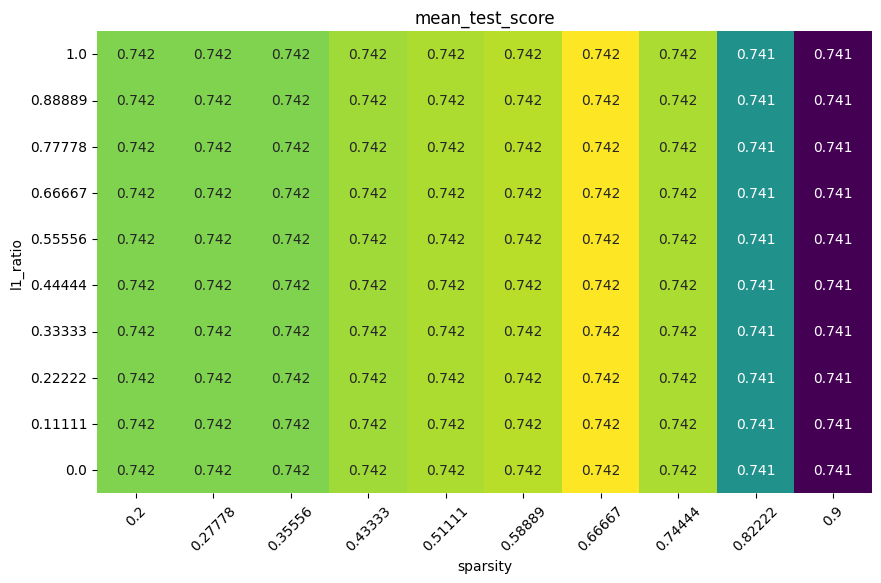

In [8]:
heatmap_part(cv_results, list(param_grid), 'mean_test_score')

In [9]:
best = (
    cv_results
    .filter(pl.col('mean_test_score') == pl.col('mean_test_score').max())
    .select(*param_grid.keys(), 'mean_test_score')
    .to_dicts()
    [0]
)
best

{'l1_ratio': 0.0,
 'sparsity': 0.6666666666666667,
 'mean_test_score': 0.7417779602214172}

In [14]:
best = {
    'sparsity': 2 / 3,
    'l1_ratio': 0.01,
}

# Learning curve

In [15]:
model = SparseEN(**best)

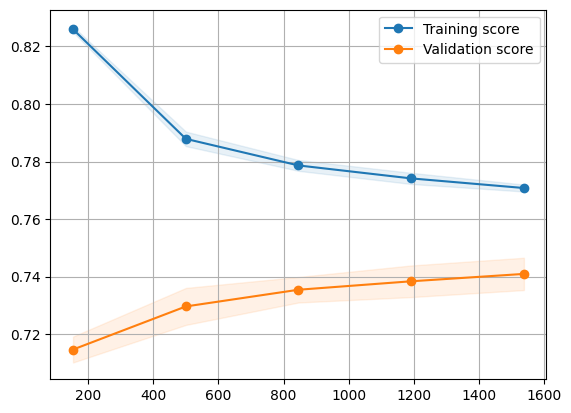

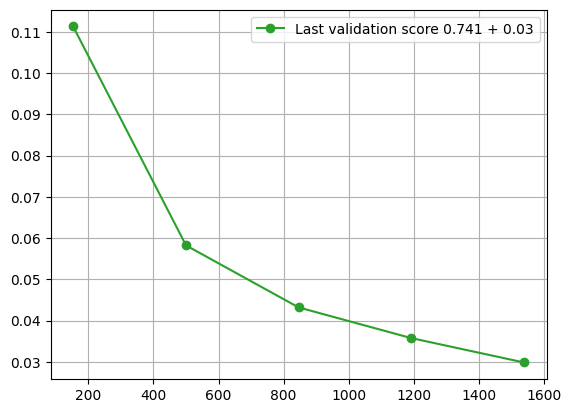

CPU times: user 611 ms, sys: 176 ms, total: 787 ms
Wall time: 4min 29s


In [16]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    model,
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

# Score on test

In [17]:
fitted_model, preds = fit_predict_sklearn_model(
    train_features, train_targets, test_features, test_targets,
    model,
)
join_truth_and_score(preds, data['test_days'], test_targets)

0.7351507011152093

# Connected components

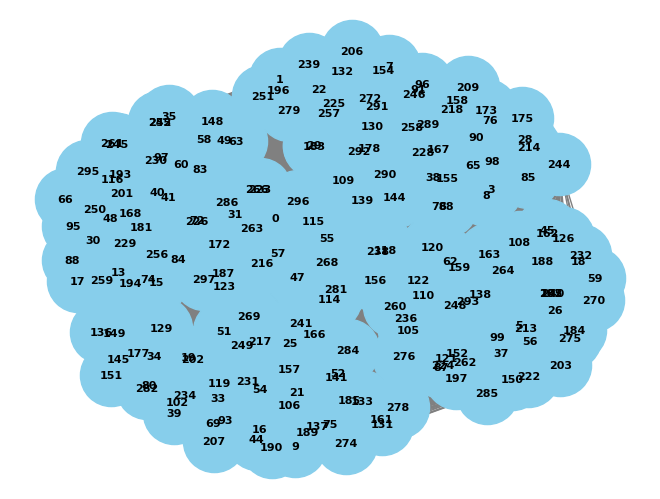

1

[CV 2/5] END ........l1_ratio=0.0, sparsity=0.2;, score=0.739 total time= 4.8min
[CV 5/5] END l1_ratio=0.0, sparsity=0.5888888888888889;, score=0.741 total time= 4.6min
[CV 3/5] END l1_ratio=0.0, sparsity=0.8222222222222222;, score=0.752 total time= 4.5min
[CV 4/5] END l1_ratio=0.1111111111111111, sparsity=0.2777777777777778;, score=0.735 total time= 5.4min
[CV 2/5] END l1_ratio=0.1111111111111111, sparsity=0.5888888888888889;, score=0.739 total time= 5.3min
[CV 1/5] END l1_ratio=0.1111111111111111, sparsity=0.9;, score=0.739 total time= 3.9min
[CV 5/5] END l1_ratio=0.2222222222222222, sparsity=0.2;, score=0.740 total time= 5.5min
[CV 1/5] END l1_ratio=0.2222222222222222, sparsity=0.5888888888888889;, score=0.741 total time= 4.1min
[CV 2/5] END l1_ratio=0.2222222222222222, sparsity=0.7444444444444445;, score=0.739 total time= 4.5min
[CV 3/5] END l1_ratio=0.3333333333333333, sparsity=0.2;, score=0.752 total time= 4.3min
[CV 2/5] END l1_ratio=0.3333333333333333, sparsity=0.43333333333333

In [19]:
graph = nx.Graph()

for component_features, component_targets in fitted_model.supports:
    for feature, is_feature in zip(data['features'], component_features):
        for target, is_target in zip(data['targets'], component_targets):
            if is_feature and is_target:
                graph.add_edge(feature, target)
                graph.add_edge(target, feature)

plt.figure()
nx.draw(
    graph,
    with_labels=True,
    node_color='skyblue',
    node_size=2000,
    font_size=8,
    font_weight='bold',
    edge_color='gray',
)
plt.show()
len(fitted_model.supports)